Sample 3 Analysis
===

Iterative analysis.

In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [321]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [322]:
from IPython.display import display, HTML

In [323]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [324]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [325]:
stub_history_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
stub_history_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [326]:
working_dir = os.path.join(derived_data_dir, 'revision_sample')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/revision_sample'

In [327]:
start_date = datetime.fromisoformat('2014-04-01').replace(tzinfo=timezone.utc)
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01').replace(tzinfo=timezone.utc)
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1396310400, 1577836800)

#### Matplotlib initialization

In [328]:
# Construct colorplot for matrix plotting
# This sets the colormap that will be used for the matrix plots below
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(plt.cm.Purples, 0, 0.6)

### Load sample 3


In [329]:
# read in the sample dataframe
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample3_filepath = os.path.join(revision_sample_dir, 'sample3_all.pkl')
rev_df = pd.read_pickle(sample3_filepath)
len(rev_df)

33964442

In [330]:
# read in the ORES scores
# as sample3 is a superset of sample2 and overlaps with sample1, we also load those scores
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
ores_dfs = []
for fname in ['sample1_ores_scores.csv', 'sample2_ores_scores.csv', 'sample3_ores_scores.csv']:
    sample_filepath = os.path.join(revision_sample_dir, fname)
    ores_dfs.append(pd.read_csv(sample_filepath, header=None, names=['rev_id', 'damaging_prob', 'damaging_pred', 'goodfaith_prob', 'goodfaith_pred']))
ores_df = pd.concat(ores_dfs, axis=0)
# remove invalid scores
ores_df = ores_df[(ores_df.damaging_prob != -1)&(ores_df.goodfaith_prob != -1)]
# remove duplicates
ores_df = ores_df.drop_duplicates(subset='rev_id')
len(ores_df)

34289314

In [331]:
# most recently available rev
last_rev = ores_df.iloc[-1].rev_id
last_rev

876227285

In [332]:
rev_df = pd.merge(rev_df, ores_df, on='rev_id', how='inner')
len(rev_df)

33782914

In [333]:
# set the analysis start time to be the beginning of 2018
analysis_start_date = datetime.fromisoformat('2018-01-01')
analysis_start_date = analysis_start_date.replace(tzinfo=timezone.utc)
analysis_start_timestamp = int(analysis_start_date.timestamp())
print(f"Starting analysis from {datetime.utcfromtimestamp(analysis_start_timestamp)}")

Starting analysis from 2018-01-01 00:00:00


In [334]:
analysis_end_timestamp = rev_df[rev_df.rev_id == last_rev].rev_timestamp.iloc[0]
print(f"Using revisions with ORES scores up to {datetime.utcfromtimestamp(analysis_end_timestamp)}")

Using revisions with ORES scores up to 2019-01-01 05:59:58


In [335]:
rev_df = rev_df[(rev_df.rev_timestamp <= analysis_end_timestamp)&(rev_df.rev_timestamp >= analysis_start_timestamp)]
len(rev_df)

33782914

In [336]:
# Damaging filter counts
# https://en.wikipedia.org/wiki/Special:ORESModels
rev_counts = np.zeros((2, 3))
for i in [0, 1]:
    for j in [0, 1, 2]:
        ores_bucket_idx = None
        if j == 0:  # likelygood
            ores_bucket_idx = rev_df.damaging_prob <= 0.329
        elif j == 1:  # neither
            ores_bucket_idx = (rev_df.damaging_prob > 0.329)&(rev_df.damaging_prob < 0.919)
        elif j == 2:  # verylikelybad
            ores_bucket_idx = rev_df.damaging_prob >= 0.919
        rev_counts[i,j] = np.sum((rev_df.is_reverted==i)&(ores_bucket_idx))
rev_counts

array([[2.6775524e+07, 3.0101380e+06, 7.2570000e+03],
       [1.8607840e+06, 1.9790680e+06, 1.5014300e+05]])

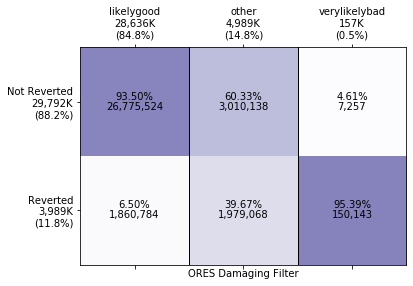

In [337]:
# revert status X ORES Damaging filter
# names for filters from https://www.mediawiki.org/wiki/ORES/RCFilters
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

rev_pcts = rev_counts.copy()
for j in range(3):
    filter_total = rev_pcts[:,j].sum()
    rev_pcts[:,j] = rev_pcts[:,j] / filter_total * 100
ax.matshow(rev_pcts, cmap=new_cmap)
plt.xlabel("ORES Damaging Filter")
ores_filter_labels = [f"{display_label}\n{int(rev_counts.sum(axis=0)[i]/1000):,}K\n({int(rev_counts.sum(axis=0)[i]) / len(rev_df) * 100:.1f}%)"
               for i, display_label
               in enumerate(['likelygood', 'other', 'verylikelybad'])
              ]
revert_labels = [f"{display_label}\n{int(np.sum(rev_df.is_reverted == i)/1000):,}K\n({np.sum(rev_df.is_reverted == i) / len(rev_df) * 100:.1f}%)"
               for i, display_label
               in enumerate(['Not Reverted', 'Reverted'])
              ]
plt.xticks(ticks=[0, 1, 2], labels=ores_filter_labels)
plt.yticks(ticks=[0, 1], labels=revert_labels)
for i in range(2):  # revert status
    for j in range(3):  # ores filter
        pct = f"{rev_pcts[i, j]:.2f}%"
        plt.text(j, i, pct, verticalalignment='bottom', horizontalalignment='center')
        count = f"{int(rev_counts[i, j]):,}"
        plt.text(j, i, count, verticalalignment='top', horizontalalignment='center')
plt.axvline(0.5, color='black', linewidth=1)
plt.axvline(1.5, color='black', linewidth=1)
plt.show()

### Load in full revision and revert data

In [18]:
start = datetime.now()
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts-v2')
rev_ids_filepath = os.path.join(stub_history_reverts_dir, 'rev_ids_sorted.csv')
df = pd.read_csv(rev_ids_filepath,
                 header=None, 
                 names=['page_id', 'rev_id', 'rev_timestamp', 'user_text', 'user_id', 'is_revert_target', 'is_reverted', 'is_reverting']
)
print(f"{datetime.now() - start}")
len(df)

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0:00:59.778084


77257328

In [19]:
# Read the revert info
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
revert_df_filepath = os.path.join(stub_history_reverts_dir, 'revert_df.pkl')
revert_df = pd.read_pickle(revert_df_filepath)
len(revert_df)

5992682

In [20]:
df.head(3)

,page_id,rev_id,rev_timestamp,user_text,user_id,is_revert_target,is_reverted,is_reverting
0,12,820024812,1515798752,Donaldtrumpisthereincarnationofjesuschrist,32836343,0,1,0
1,12,820025687,1515799060,C.J. Griffin,3341545,0,0,1
2,12,820703495,1516095884,Ira Leviton,25046916,0,0,0


In [21]:
revert_df.head(3)

,page_id,reverted_count,reverting_rev_id,reverting_timestamp,reverting_user_text,reverting_user_id,reverted_to_rev_id,reverted_to_timestamp,reverted_to_user_text,reverted_to_user_id,reverted_rev_ids,reverted_timestamps,reverted_user_texts,reverted_user_ids,reverting_user_is_anonymous,reverted_to_user_is_anonymous,reverted_users_is_anonymous
0,18754764,1,902766646,1561105801,Malcolmxl5,4076676.0,874884880,1545481829,Hmains,508734.0,[900328973],[1559706521],[2601:199:417F:8EED:A0B0:A6B5:3457:A9B4],[None],False,False,[True]
1,18754831,2,818980415,1515284429,BrownHairedGirl,754619.0,743241620,1475970276,Emir of Wikipedia,28856560.0,"[757539852, 775847398]","[1483188655, 1492452285]","[Ser Amantio di Nicolao, Emir of Wikipedia]","[753665, 28856560]",False,False,"[False, False]"
2,18754831,1,932235094,1577204938,UA3,25923702.0,918313790,1569654385,Monkbot,20483999.0,[932233860],[1577204033],[Qowa],[37692801],False,False,[False]


### Other preprocessing

Adding other columns for easier analysis.

In [22]:
revert_df['is_multirevert'] = revert_df.reverted_count > 1

#### Changeset identification and analysis

In [23]:
df = df[(df.rev_timestamp >= analysis_start_timestamp)&(df.rev_timestamp <= analysis_end_timestamp)]
len(df)

13455953

In [24]:
curr_page_id = -1
prev_user_text = ""

is_in_changeset_list = []
changeset_ids = []
changeset_id_counter = 0
for row in tqdm(df.itertuples(), total=len(df)):
    page_id = row.page_id
    user_text = row.user_text
    if page_id != curr_page_id:
        curr_page_id = page_id
        is_in_changeset_list.append(False)
        changeset_id = changeset_id_counter
        changeset_id_counter += 1
        changeset_ids.append(changeset_id)
    else:
        if prev_user_text == user_text:
            # this is a changeset!
            if is_in_changeset_list[-1]:
                # this is an existing changeset
                changeset_id = changeset_ids[-1]
            else:  # this is a brand new changeset!
                is_in_changeset_list[-1] = True
                changeset_id = changeset_id_counter
                changeset_id_counter += 1
                changeset_ids[-1] = changeset_id
            is_in_changeset_list.append(True)
            changeset_ids.append(changeset_id)
        else: # this is not a changeset!
            is_in_changeset_list.append(False)
            changeset_id = changeset_id_counter
            changeset_id_counter += 1
            changeset_ids.append(changeset_id)
    prev_user_text = user_text

100%|██████████| 13455953/13455953 [00:33<00:00, 402587.02it/s]


In [25]:
df['is_in_multirev_changeset'] = is_in_changeset_list
df['changeset_id'] = changeset_ids

In [92]:
changeset_id_counter = Counter(df.changeset_id)
df['changeset_size'] = df.changeset_id.map(lambda changeset_id: changeset_id_counter[changeset_id])

In [26]:
# an absurd 49% of revisions are in changesets
np.sum(df.is_in_multirev_changeset) / len(df)

0.495352800355352

In [27]:
# number of unique changesets
len(set(df.changeset_id)), len(set(df.changeset_id)) / len(df)

(8597256, 0.6389184028808662)

In [28]:
# number of unique multirevision changesets
df_subset = df[df.is_in_multirev_changeset]
len(set(df_subset.changeset_id)), len(set(df_subset.changeset_id)) / len(df_subset)

(1806747, 0.27106176272728416)

In [29]:
# 22% of changesets have multiple revisions
len(set(df_subset.changeset_id)) / len(set(df.changeset_id))

0.21015391422565524

In [30]:
rev_id_changeset_dict = {row.rev_id: row.changeset_id for row in df.itertuples()}

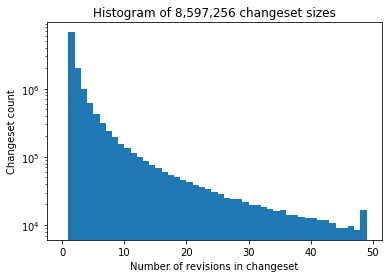

In [98]:
plt.hist(df.changeset_size, log=True, bins=range(50))
plt.title(f"Histogram of {len(set(df.changeset_id)):,} changeset sizes")
plt.xlabel("Number of revisions in changeset")
plt.ylabel("Changeset count")
plt.show()

In [104]:
# confirming that the number of >1-revision changeset count is the same as computed above
np.sum(np.array([v for v in changeset_id_counter.values()]) > 1)

1806747

### Analyze reverts

In [31]:
analysis_rev_ids = set(rev_df.rev_id)

In [32]:
revert_subset = revert_df[revert_df.reverting_rev_id.isin(analysis_rev_ids)].copy()
len(revert_subset), len(revert_subset) / len(revert_df)

(1014839, 0.1693463794674905)

In [44]:
#revert_subset['all_reverted_in_analysis_set'] = revert_subset.reverted_rev_ids.map(
#    lambda reverted_rev_ids: np.all([rev_id in analysis_rev_ids for rev_id in reverted_rev_ids])
#)

In [46]:
#revert_subset = revert_subset[revert_subset.all_reverted_in_analysis_set].copy()
#len(revert_subset), len(revert_subset) / len(revert_df)

(56266, 0.00938911826123929)

In [33]:
revert_subset['reverted_changeset_ids'] = revert_subset.reverted_rev_ids.map(
    lambda reverted_rev_ids: [rev_id_changeset_dict[rev_id] for rev_id in reverted_rev_ids if rev_id in rev_id_changeset_dict]
)

In [35]:
# only a tiny number of reverts have reverted revisions without changeset assignments
num_changeset_ids = revert_subset.reverted_changeset_ids.map(len)
no_changeset_assigned_count = np.sum(num_changeset_ids < revert_subset.reverted_count)
no_changeset_assigned_count, f"{no_changeset_assigned_count / len(revert_subset) * 100:.2f}%"

(5195, '0.51%')

In [36]:
revert_subset['reverted_unique_changeset_count'] = revert_subset.reverted_changeset_ids.map(lambda reverted_changeset_ids: len(set(reverted_changeset_ids)))

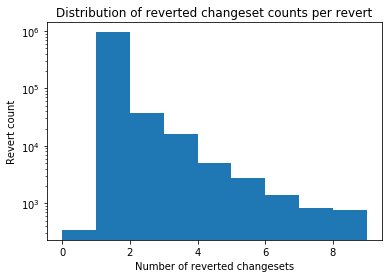

In [38]:
plt.hist(revert_subset.reverted_unique_changeset_count, log=True, bins=range(10))
plt.title("Distribution of reverted changeset counts per revert")
plt.xlabel("Number of reverted changesets")
plt.ylabel("Revert count")
plt.show()

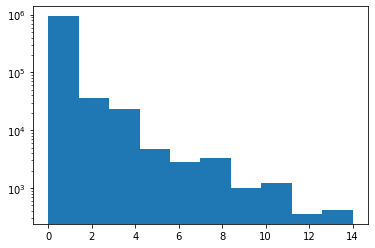

In [39]:
plt.hist(revert_subset.reverted_count - revert_subset.reverted_unique_changeset_count, log=True)
plt.show()

In [42]:
revert_subset['is_changeset_multirevert'] = revert_subset.reverted_unique_changeset_count > 1

In [43]:
pd.crosstab(revert_subset.is_multirevert, revert_subset.is_changeset_multirevert, margins=True)

is_changeset_multirevert,False,True,All
is_multirevert,,,
False,800843,0,800843
True,149438,64558,213996
All,950281,64558,1014839


In [66]:
# 70% of multi-reverts are actually single-changeset reverts
149438 / 213996

0.6983214639525972

In [52]:
np.sum(revert_subset.reverted_unique_changeset_count >= 2) / np.sum(revert_subset.reverted_unique_changeset_count >= 1)

0.0669167451865811

In [219]:
likelygood = rev_df[rev_df.damaging_prob <= 0.329]
len(likelygood)

8950244

In [220]:
reverted_likelygood = likelygood[likelygood.is_reverted == 1]
len(reverted_likelygood)

588413

In [59]:
is_self_revert_list = []
for row in tqdm(revert_df.itertuples(), total=len(revert_df)):
    is_self_revert = row.reverting_user_text in row.reverted_user_texts
    is_self_revert_list.append(is_self_revert)
revert_df['is_self_revert'] = is_self_revert_list

100%|██████████| 5992682/5992682 [00:23<00:00, 257102.09it/s]


In [60]:
reverting_rev_id_self_revert_dict = {row.reverting_rev_id: row.is_self_revert for row in revert_df.itertuples()}

In [61]:
reverted_likelygood['is_self_revert'] = \
    reverted_likelygood.reverting_rev_id.map(lambda reverting_rev_id: reverting_rev_id_self_revert_dict[reverting_rev_id])

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
np.sum(reverted_likelygood.is_self_revert) / len(reverted_likelygood)

0.22089317332284084

In [66]:
np.sum(reverted_likelygood.is_self_revert), len(reverted_likelygood)

(11228, 50830)

In [64]:
notlikelygood = rev_df[rev_df.damaging_prob > 0.329]
reverted_notlikelygood = notlikelygood[notlikelygood.is_reverted == 1]
reverted_notlikelygood['is_self_revert'] = \
    reverted_notlikelygood.reverting_rev_id.map(lambda reverting_rev_id: reverting_rev_id_self_revert_dict[reverting_rev_id])
np.sum(reverted_notlikelygood.is_self_revert) / len(reverted_notlikelygood)

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.08950744182221856

## Non-reverts

In [44]:
verylikelybad = rev_df[rev_df.damaging_prob >= 0.919]
len(verylikelybad)

52368

In [45]:
nonreverted_verylikelybad = verylikelybad[verylikelybad.is_reverted == 0]
len(nonreverted_verylikelybad)

2415

In [57]:
rev_id_damaging_dict = {row.rev_id: row.damaging_prob for row in rev_df.itertuples()}

In [83]:
curr_page_id = -1
prev_rev_id = -1
next_rev_id_dict = {}
prev_rev_id_dict = {}
for row in tqdm(df.itertuples(), total=len(df)):
    page_id = row.page_id
    if page_id != curr_page_id:
        curr_page_id = page_id
    else:
        if prev_rev_id != -1:
            next_rev_id_dict[prev_rev_id] = row.rev_id
            prev_rev_id_dict[row.rev_id] = prev_rev_id
    prev_rev_id = row.rev_id


100%|██████████| 13455953/13455953 [00:40<00:00, 331521.79it/s]


In [84]:
# expected pattern: non-reverted verylikelybad are often preceded by another revision in the same changeset
# basically, these are "partial self-reverts"
is_partial_selfrevert_list = []
for row in tqdm(nonreverted_verylikelybad.itertuples(), total=len(nonreverted_verylikelybad)):
    rev_id = row.rev_id
    if rev_id not in rev_id_changeset_dict:
        continue
    changeset_id = rev_id_changeset_dict[rev_id]
    
    # is changeset
    is_partial_selfrevert = False
    while True:
        if rev_id in next_rev_id_dict:
            next_rev_id = next_rev_id_dict[rev_id]
            if next_rev_id in rev_id_changeset_dict and rev_id_changeset_dict[next_rev_id] == changeset_id:
                if next_rev_id in rev_id_damaging_dict and rev_id_damaging_dict[next_rev_id] < 0.919:
                    # following non-damaging edit in the same changeset!
                    is_partial_selfrevert = True
                    break
                else:
                    rev_id = next_rev_id
            else:
                break
        else:
            break
    
    is_partial_selfrevert_list.append(is_partial_selfrevert)


100%|██████████| 2415/2415 [00:00<00:00, 73078.35it/s]


In [85]:
partial_selfrevert_count = np.sum(is_partial_selfrevert_list)
partial_selfrevert_count, partial_selfrevert_count / len(nonreverted_verylikelybad)

(1065, 0.4409937888198758)

In [86]:
nonreverted_verylikelybad['is_partial_selfrevert'] = is_partial_selfrevert_list

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
nonreverted_verylikelybad = pd.merge(nonreverted_verylikelybad, df[['rev_id', 'changeset_id', 'changeset_size']], on='rev_id', how='left')

In [108]:
# no nas introduced when merging in changeset info
np.sum(nonreverted_verylikelybad.isna())

page_id                    0
rev_id                     0
rev_timestamp              0
is_revert_target           0
is_reverted                0
is_reverting               0
is_sample_eligible         0
prev_rev_id                0
next_rev_id                0
prev_rev_timestamp         0
next_rev_timestamp         0
reverted_rev_ids           0
reverting_rev_id           0
reverting_rev_timestamp    0
damaging_prob              0
damaging_pred              0
goodfaith_prob             0
goodfaith_pred             0
is_partial_selfrevert      0
changeset_id               0
changeset_size             0
dtype: int64

In [110]:
nonreverted_verylikelybad_subset = nonreverted_verylikelybad[(nonreverted_verylikelybad.is_partial_selfrevert)&(nonreverted_verylikelybad.changeset_size == 2)]
print(len(nonreverted_verylikelybad_subset), len(nonreverted_verylikelybad))
for row in nonreverted_verylikelybad_subset.sample(n=10, random_state=10).itertuples():
    url = f"https://en.wikipedia.org/wiki/?diff={row.rev_id}"
    
    changeset_scores = []
    rev_id = row.rev_id
    changeset_scores.append(rev_id_damaging_dict[rev_id])
    changeset_id = rev_id_changeset_dict[rev_id]
    while True:
        if rev_id in next_rev_id_dict:
            next_rev_id = next_rev_id_dict[rev_id]
            if next_rev_id in rev_id_changeset_dict and rev_id_changeset_dict[next_rev_id] == changeset_id:
                if next_rev_id in rev_id_damaging_dict:
                    changeset_scores.append(rev_id_damaging_dict[next_rev_id])
                else:
                    changeset_scores.append("n/a")
                rev_id = next_rev_id
            else:
                #print("Out of changeset...")
                break
        else:
            #print("No next rev...")
            break
    # now retrieve any previous entries...
    rev_id = row.rev_id
    while True:
        if rev_id in prev_rev_id_dict:
            prev_rev_id = prev_rev_id_dict[rev_id]
            if prev_rev_id in rev_id_changeset_dict and rev_id_changeset_dict[prev_rev_id] == changeset_id:
                if prev_rev_id in rev_id_damaging_dict:
                    changeset_scores.insert(0, f"p({rev_id_damaging_dict[prev_rev_id]:.2f})")
                else:
                    changeset_scores.append("p(n/a)")
                rev_id = prev_rev_id
            else:
                break
        else:
            break
    score_string = ",".join([f"{s:.2f}" if type(s) == float else s for s in changeset_scores])
    print(f"{row.rev_id}\t{url}\t{score_string}")

374 2415
830131461	https://en.wikipedia.org/wiki/?diff=830131461	0.95,0.53
835967433	https://en.wikipedia.org/wiki/?diff=835967433	0.94,0.58
826171559	https://en.wikipedia.org/wiki/?diff=826171559	0.94,0.47
828267461	https://en.wikipedia.org/wiki/?diff=828267461	0.96,0.89
837591995	https://en.wikipedia.org/wiki/?diff=837591995	0.93,0.45
829680779	https://en.wikipedia.org/wiki/?diff=829680779	0.92,0.49
830708145	https://en.wikipedia.org/wiki/?diff=830708145	0.93,0.28
835345313	https://en.wikipedia.org/wiki/?diff=835345313	0.95,0.49
827288939	https://en.wikipedia.org/wiki/?diff=827288939	0.93,0.01
823916706	https://en.wikipedia.org/wiki/?diff=823916706	0.93,0.34


In [139]:
len(set(nonreverted_verylikelybad[nonreverted_verylikelybad.is_partial_selfrevert].rev_id))

1065

In [221]:
with open("/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/text_content/revid_reverted_likelygood.txt", 'w') as outfile:
    for rev_id in reverted_likelygood.rev_id:
        if rev_id and rev_id != -1:
            outfile.write(f"{rev_id}\n")
print("Finished.")

Finished.


In [166]:
nonreverted_verylikelybad.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,...,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp,damaging_prob,damaging_pred,goodfaith_prob,goodfaith_pred,is_partial_selfrevert,changeset_id,changeset_size
0,655,833425454,1522520513,0,0,0,True,828367712,833427405,1519982382,...,[],-1,-1,0.924871,True,0.095596,False,False,1130308,1
1,2543,825117776,1518387505,0,0,0,True,825114760,825119579,1518386261,...,[],-1,-1,0.919114,True,0.094052,False,True,712942,3
2,2824,819520028,1515552003,0,0,0,True,819519420,819524047,1515551762,...,[],-1,-1,0.930973,True,0.097064,False,True,2049386,3
3,2835,829154320,1520401707,0,0,0,True,822086008,829154832,1516806117,...,[],-1,-1,0.957686,True,0.152042,False,True,14698,2
4,2947,826645751,1519133685,0,0,0,True,825779582,826645783,1518713265,...,[],-1,-1,0.959006,True,0.053714,False,True,2086047,2


In [76]:
833042571 in set(nonreverted_verylikelybad[nonreverted_verylikelybad.is_partial_selfrevert].rev_id)

True

In [113]:
# to investigate: why is 830131514 not considered a revert of 830131461?
# my answer from inspecting the diff: a single trailing space was deleted
# thus, this is a "de-facto" revert
# want to automate identifying partial reverts that result only in whitespace differences
df[df.rev_id == 830131461]

,page_id,rev_id,rev_timestamp,user_text,user_id,is_revert_target,is_reverted,is_reverting,is_in_multirev_changeset,changeset_id,changeset_size
65494481,13557483,830131461,1520913658,98.230.129.75,NaN,0,0,0,True,8896072,2


In [188]:
def get_db(db_filename):
    db = sqlite3.connect(
            db_filename,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_revision_texts(rev_ids):
    texts = []
    try:
        db_filepath = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/text_content/revisionText.sqlite"
        db = get_db(db_filepath)
        for rev_id in rev_ids:
            rev_id = int(rev_id)
            cursor = db.execute("SELECT rev_id, content, comment, tags FROM revisionText WHERE rev_id = ?", (rev_id,))
            result = cursor.fetchall()
            # unlike the others, there might be multiple comments
            if len(result) > 1:
                # This should never happen if the database is properly constructed...
                print("WARNING: Duplicated rev_id in database, check integrity.")
            if len(result) == 0:
                print(f"Failed to find rev_id {rev_id} in database.")
                continue
            result = result[0]
            d = {
                'rev_id': rev_id,
                'content': result['content'],
                'comment': result['comment'],
                'tags': result['tags'],
            }
            texts.append(d)
    finally:
        db.close()
    return texts

In [154]:
texts = get_revision_texts(nonreverted_verylikelybad.rev_id)

In [156]:
len(texts), len(nonreverted_verylikelybad)

(2414, 2415)

In [157]:
text_df = pd.DataFrame(texts)
text_df.head()

,rev_id,content,comment,tags
0,833425454,{{Other uses}}\n{{Redirect2|Abaci|Abacuses|the...,,Section blanking
1,825117776,\n{{About|the Russian politician|the fictiona...,"/* Personal life */ edited to include exile, d...",Section blanking
2,819520028,{{for2|the song by Amanda Lear|[[Alphabet (Ama...,/* Dutch version */,
3,829154320,{{Infobox dog breed\n| image = File:Afghane.jp...,Added info,mobile edit|mobile web edit
4,826645751,{{More citations needed|date=March 2016}}\n:''...,,


In [158]:
np.sum(text_df.comment == "")

933

In [161]:
Counter(text_df.tags).most_common(10)

[('', 1214),
 ('mobile edit|mobile web edit', 683),
 ('visualeditor', 134),
 ('mobile edit|mobile web edit|visualeditor', 92),
 ('Section blanking', 55),
 ('mobile edit|mobile web edit|canned edit summary', 43),
 ('mobile edit|mobile app edit', 38),
 ('references removed', 25),
 ('mobile edit|mobile web edit|Section blanking', 16),
 ('mobile edit|mobile web edit|possible libel or vandalism', 12)]

In [162]:
# revision 820214494 has been deleted
set(nonreverted_verylikelybad.rev_id) - set(text_df.rev_id)

{820214494}

In [308]:
# compare the prev and next revisions nonreverted_verylikelybad_subset
sdf = nonreverted_verylikelybad.copy()
start = datetime.now()
rev_ids = np.concatenate((sdf.prev_rev_id, sdf.rev_id, sdf.next_rev_id))
texts = get_revision_texts(rev_ids)
text_df = pd.DataFrame(texts)
sdf = pd.merge(sdf, text_df[['rev_id', 'content']], left_on='prev_rev_id', right_on='rev_id', suffixes=('', '_copy')).rename(columns={
    'content': 'prev_content'
}).drop(columns='rev_id_copy')
sdf = pd.merge(sdf, text_df[['rev_id', 'content']], left_on='next_rev_id', right_on='rev_id', suffixes=('', '_copy')).rename(columns={
    'content': 'next_content'
}).drop(columns='rev_id_copy')
sdf = pd.merge(sdf, text_df[['rev_id', 'content', 'comment']], on='rev_id').rename(columns={
    'content': 'rev_content',
    'comment': 'rev_comment',
})
#sdf = pd.merge(sdf, df[['rev_id', 'changeset_size']], on='rev_id')
print(f"{datetime.now() - start}")
len(sdf)

Failed to find rev_id 818566333 in database.
Failed to find rev_id 820214494 in database.
Failed to find rev_id 820890359 in database.
0:00:01.057340


2635

In [309]:
is_nonwhitespace_revert_list = []
for row in sdf.itertuples():
    prev_content = re.sub(r"\s+", '', row.prev_content)
    next_content = re.sub(r"\s+", '', row.next_content)
    is_nonwhitespace_revert = False
    if prev_content == next_content:
        is_nonwhitespace_revert = True        
    is_nonwhitespace_revert_list.append(is_nonwhitespace_revert)
sdf['is_nonwhitespace_revert'] = is_nonwhitespace_revert_list
np.sum(sdf.is_nonwhitespace_revert)

116

In [310]:
# nearly 5% meet are partial "non-whitespace" reverts
# meaning that the text is identical but for whitespace, not including carriage returns
np.sum(sdf.is_nonwhitespace_revert) / len(sdf)

0.04402277039848197

In [311]:
np.sum(sdf.changeset_size > 1)

1609

In [316]:
# print a few diffs for quick inspection
sample_list = []
context_chars = 50
for row in sdf[(sdf.changeset_size == 1)&(~sdf.is_nonwhitespace_revert)].sample(n=50, random_state=0).itertuples():
    comment = row.rev_comment        
    url = f"https://en.wikipedia.org/wiki/?diff={row.rev_id}"

    diff_str = ""
    prev_a_start = None
    prev_b_start = None
    prev_size = -1
    l1, l2 = row.prev_content, row.rev_content
    for a_start, b_start, size in difflib.SequenceMatcher(a=l1, b=l2).get_matching_blocks():
        if prev_a_start is not None:
            a_diff = l1[prev_a_start + prev_size:a_start]
            b_diff = l2[prev_b_start + prev_size:b_start]
            if a_diff != b_diff:
                diff_str += f"▛{a_diff}❚{b_diff}▜"
        if size > context_chars * 2 + 5:
            diff_str += l1[a_start:a_start+context_chars] + "<...>" + l1[a_start+size-context_chars:a_start+size]
        else:
            diff_str += l1[a_start:a_start+size]
        prev_a_start = a_start
        prev_b_start = b_start
        prev_size = size

    d = {
        'rev_id': row.rev_id,
        'url': url,
        'comment': row.rev_comment,
        'diff': diff_str
    }
    sample_list.append(d)
sample = pd.DataFrame(sample_list)
sample.head()

,rev_id,url,comment,diff
0,836112667,https://en.wikipedia.org/wiki/?diff=836112667,"/* Characters */Fixed minor mistakes, added co...",{{about|the book series|the film series|Maze R...
1,819408717,https://en.wikipedia.org/wiki/?diff=819408717,,{{Redirect|Black Spider-Man|the black Spider-M...
2,836516917,https://en.wikipedia.org/wiki/?diff=836516917,,{{outdated|date=January 2018}}\n{{Infobox econ...
3,830385208,https://en.wikipedia.org/wiki/?diff=830385208,/* Opera */,[[File:DraculaWaxMuseum.JPG|thumb|right|Bela L...
4,829729634,https://en.wikipedia.org/wiki/?diff=829729634,/* Canada */,A '''points-based immigration system''' is an ...


In [319]:
len(sample), len(sdf[(sdf.changeset_size == 1)&(~sdf.is_nonwhitespace_revert)])

(50, 993)

In [318]:
sample_filepath = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/sample3-annotation/nonreverted_vlb_nonmulti_nonwhitespace_n50.csv"
sample.to_csv(sample_filepath)
print("Finished.")

Finished.


In [298]:
# print a few diffs for quick inspection
context_chars = 50
for row in sdf.sample(n=50, random_state=0).itertuples():
    if not row.is_nonwhitespace_revert:
        prev_content = row.prev_content.splitlines(keepends=True)
        next_content = row.rev_content.splitlines(keepends=True)
        
        comment = row.rev_comment
        print(f"Comment: '{comment}'")
        
        url = f"https://en.wikipedia.org/wiki/?diff={row.rev_id}"
        print(url)
        
        diff_str = ""
        prev_a_start = None
        prev_b_start = None
        prev_size = -1
        l1, l2 = row.prev_content, row.rev_content
        for a_start, b_start, size in difflib.SequenceMatcher(a=l1, b=l2).get_matching_blocks():
            if prev_a_start is not None:
                a_diff = l1[prev_a_start + prev_size:a_start]
                b_diff = l2[prev_b_start + prev_size:b_start]
                if a_diff != b_diff:
                    diff_str += f"▛{a_diff}❚{b_diff}▜"
            if size > context_chars * 2 + 5:
                diff_str += l1[a_start:a_start+context_chars] + "<...>" + l1[a_start+size-context_chars:a_start+size]
            else:
                diff_str += l1[a_start:a_start+size]
            prev_a_start = a_start
            prev_b_start = b_start
            prev_size = size
        print(diff_str)
        print()
                
        print(f"~~End of diffs in {row.rev_id}~~\n")

Comment: ''
https://en.wikipedia.org/wiki/?diff=837999665
{{Other uses}}
{{Refimprove|date=December 2017}}
[<...>per second squared|meter per second per second]].
▛❚gjlöhvfc  nrhvthgutzbrgvctvrfdc▜
In [[mechanical engineering]], force [[orthogonal<...>[[helical gear]]s) is referred to as '''thrust'''.▛❚ Now go to the toilet▜

==Examples==
[[Image:aeroforces.svg|thumb|Forces<...>s]]
[[Category:Force]]
[[Category:Temporal rates]]

~~End of diffs in 837999665~~

Comment: ''
https://en.wikipedia.org/wiki/?diff=821637461
{{Use mdy dates|date=March 2017}}
{{Redirect|FoxBo<...>iginally known as '''FoxBox''' from 2002 to 2005) ▛was a❚is <!---(we use present tense in articles; don't change this to 'was'. It's going to be immediately reverted.)---> a defunct ▜ [[block programming|television programming block]<...>Category:2008 American television series endings]]

~~End of diffs in 821637461~~

Comment: 'Better phrasing in the prevention section.'
https://en.wikipedia.org/wiki/?diff=819737812
{{

In [ ]:
nonreverted_verylikelybad_subset = nonreverted_verylikelybad[(nonreverted_verylikelybad.is_partial_selfrevert)&(nonreverted_verylikelybad.changeset_size == 2)]
print(len(nonreverted_verylikelybad_subset))

In [ ]:
rev_ids = np.concatenate((nonreverted_verylikelybad_subset.prev_rev_id, nonreverted_verylikelybad_subset.rev_id, nonreverted_verylikelybad_subset.next_rev_id))
texts = get_revision_texts(rev_ids)
text_df = pd.DataFrame(texts)
len(text_df), len(rev_ids)

In [198]:
# compare the prev and next revisions nonreverted_verylikelybad_subset
sdf = nonreverted_verylikelybad_subset.copy()
sdf = pd.merge(sdf, text_df[['rev_id', 'content']], left_on='prev_rev_id', right_on='rev_id', suffixes=('', '_copy')).rename(columns={
    'content': 'prev_content'
}).drop(columns='rev_id_copy')
sdf = pd.merge(sdf, text_df[['rev_id', 'content']], left_on='next_rev_id', right_on='rev_id', suffixes=('', '_copy')).rename(columns={
    'content': 'next_content'
}).drop(columns='rev_id_copy')

In [270]:
is_nonwhitespace_revert_list = []
for row in sdf.itertuples():
    prev_content = re.sub(r"\s+", '', row.prev_content)
    next_content = re.sub(r"\s+", '', row.next_content)
    is_nonwhitespace_revert = False
    if prev_content == next_content:
        is_nonwhitespace_revert = True
    else:
        prev_content = row.prev_content.splitlines(keepends=True)
        next_content = row.next_content.splitlines(keepends=True)
        
        url = f"https://en.wikipedia.org/wiki/?diff={row.rev_id}"
        print(url)
        
        diff_count = 0
        line_count = 0
        prev_diff_line = -1
        for l1, l2 in zip(row.prev_content.splitlines(),row.next_content.splitlines()):
            if l1 != l2:
                # TODO could adjust this to do a look-ahead: 
                # if the next line is also mismatched, assume this is a multi-line change,
                # and use all lines together (with \n's) in the SequenceMatcher
                diff_count += 1
                if diff_count >= 2 and prev_diff_line + 1 == line_count:
                    print("<Changes in adjacent rows, snipping rest of revision diff.>")
                    break                
                diff_str = ""
                prev_a_start = None
                prev_b_start = None
                prev_size = -1
                for a_start, b_start, size in difflib.SequenceMatcher(a=l1, b=l2).get_matching_blocks():
                    #if size == 0:
                    #    continue
                    if prev_a_start is not None:
                        a_diff = l1[prev_a_start + prev_size:a_start]
                        b_diff = l2[prev_b_start + prev_size:b_start]
                        if a_diff != b_diff:
                            diff_str += f"▛{a_diff}❚{b_diff}▜"
                    diff_str += l1[a_start:a_start+size]
                    prev_a_start = a_start
                    prev_b_start = b_start
                    prev_size = size
                print(diff_str)
                print()
                
                prev_diff_line = line_count
            line_count += 1
        print(f"~~End of diffs in {row.rev_id}~~\n")
        
        #diff = difflib.ndiff(prev_content, next_content)
        #print(''.join(diff), end="")

        #table = difflib.HtmlDiff(tabsize=2, wrapcolumn=75).make_table(prev_content, next_content, context=True)
        #display(HTML(table))
    is_nonwhitespace_revert_list.append(is_nonwhitespace_revert)
#sdf['is_nonwhitespace_revert'] = is_nonwhitespace_revert_list
#np.sum(sdf.is_nonwhitespace_revert)


https://en.wikipedia.org/wiki/?diff=829154320
The '''Afghan Hound''' is a [[hound]] that is distinguished by its thick, fine, silky coat and its tail with a ring curl at the end. The breed ▛wa❚i▜s selectively bred for its unique features in the cold mountains of [[Afghanistan]]. Its local name is '''Tāžī Spay''' ({{lang-ps|تاژي سپی}}) or '''Sag-e Tāzī''' ([[Dari Persian]]: سگ تازی). Other names for this breed are ''[[Kuchi (dog)|Kuchi Hound]]'', ''Tāzī'', ''Balkh Hound'', ''Baluchi Hound'', ''[[Barakzai]] Hound'', ''Shalgar Hound'', ''Kabul Hound'', ''Galanday Hound'' or sometimes incorrectly ''African Hound''.

~~End of diffs in 829154320~~

https://en.wikipedia.org/wiki/?diff=829210342
* [[Eduard Krebsbach]], * August 8, 1894 † May 28, 1947 in Landsberg am Lech, ▛❚SS ▜doctor in ▛❚Nazi Mau▜th▛❚aus▜e▛❚n▜ concentration camp ▛Ma❚exec▜ut▛h❚ed for w▜a▛u❚r crime▜s▛en❚▜

* [[Sebastian Stahl]] born September 20, 1978, ▛German ❚▜race car driver

~~End of diffs in 829210342~~

https://en.wikipe

In [261]:
diff_str = ""
prev_a_start = None
prev_b_start = None
prev_size = -1
for a_start, b_start, size in difflib.SequenceMatcher(a=l1, b=l2).get_matching_blocks():
    if size == 0:
        continue
    if prev_a_start is not None:
        a_diff = l1[prev_a_start + prev_size:a_start]
        b_diff = l2[prev_b_start + prev_size:b_start]
        diff_str += f"▛{a_diff}―{b_diff}▜"
    diff_str += l1[a_start:a_start+size]
    prev_a_start = a_start
    prev_b_start = b_start
    prev_size = size
print(diff_str)

The '''Afghan Hound''' is a [[hound]] that is distinguished by its thick, fine, silky coat and its tail with a ring curl at the end. The breed ▛wa―i▜s selectively bred for its unique features in the cold mountains of [[Afghanistan]]. Its local name is '''Tāžī Spay''' ({{lang-ps|تاژي سپی}}) or '''Sag-e Tāzī''' ([[Dari Persian]]: سگ تازی). Other names for this breed are ''[[Kuchi (dog)|Kuchi Hound]]'', ''Tāzī'', ''Balkh Hound'', ''Baluchi Hound'', ''[[Barakzai]] Hound'', ''Shalgar Hound'', ''Kabul Hound'', ''Galanday Hound'' or sometimes incorrectly ''African Hound''.


In [259]:
l1[145]

"The '''Afghan Hound''' is a [[hound]] that is distinguished by its thick, fine, silky coat and its tail with a ring curl at the end. The breed was selectively bred for its unique features in the cold mountains of [[Afghanistan]]. Its local name is '''Tāžī Spay''' ({{lang-ps|تاژي سپی}}) or '''Sag-e Tāzī''' ([[Dari Persian]]: سگ تازی). Other names for this breed are ''[[Kuchi (dog)|Kuchi Hound]]'', ''Tāzī'', ''Balkh Hound'', ''Baluchi Hound'', ''[[Barakzai]] Hound'', ''Shalgar Hound'', ''Kabul Hound'', ''Galanday Hound'' or sometimes incorrectly ''African Hound''."

In [202]:
np.sum(sdf.is_nonwhitespace_revert) / len(sdf)

0.14705882352941177

In [226]:
set("test\t") ^ set("test ")

{'\t', ' '}